# Crack 이미지 분류

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import glob
from PIL import Image

import torch
import torchvision.transforms as T
import torchvision.models as models

import timm

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# CustomDataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(len(classes)):
            root_dir = os.path.join(dir, classes[i])
            img_list = os.listdir(root_dir)
            for img in img_list:
                if img != ".DS_Store":
                    self.data.append((os.path.join(root_dir, img), i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx][0], self.data[idx][1]
        img = Image.open(img).convert('RGB')
        img = self.transforms(img)

        return img, label

In [4]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
classes = ['crack', 'normal']

train_dataset = CustomDataset("/Users/kimhongseok/cv_79_projects/part2/29/data/train", classes, transforms)
valid_dataset = CustomDataset("/Users/kimhongseok/cv_79_projects/part2/29/data/val", classes, transforms)
test_dataset = CustomDataset("/Users/kimhongseok/cv_79_projects/part2/29/data/test", classes, transforms)

In [5]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

35550
3300
200


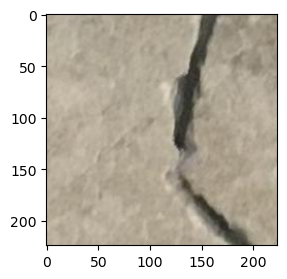

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.show()

# dataloader

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=100, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# trainig, evaluation

In [8]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accracy += (predicted==labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accracy /= len(train_dataset)

    return model, train_loss, train_accracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(probs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')
        
    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_accuracy_list = []
    train_loss_list = []
    valid_accuracy_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)

    return model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

# model

In [9]:
#model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)

In [10]:
#model

In [11]:
'''
for params in model.parameters():
    params.requires_grad == False

for params in model.head.parameters():
    params.requires_grad = True
'''

'\nfor params in model.parameters():\n    params.requires_grad == False\n\nfor params in model.head.parameters():\n    params.requires_grad = True\n'

In [12]:
'''
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
'''

'\ncriterion = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr = 0.001)\nschedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)\n'

# train 수행

In [13]:
# model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 50)

# resnet34

In [14]:
model = timm.create_model('resnet18', pretrained=True, num_classes=2)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [15]:
for params in model.parameters():
    params.requires_grad = False

for params in model.fc.parameters():
    params.requires_grad = True

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [17]:
model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 50)

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Train Loss: 0.22741054027770344, Train Accuracy: 0.9621378340365682, Valid Loss: 0.10821757939728824, Valid Accuracy: 0.9839393939393939


  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Train Loss: 0.08618096728924285, Train Accuracy: 0.9842756680731364, Valid Loss: 0.06544007123871283, Valid Accuracy: 0.9863636363636363


  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Train Loss: 0.061334356545271834, Train Accuracy: 0.9877355836849507, Valid Loss: 0.054463955206852974, Valid Accuracy: 0.9878787878787879


  0%|          | 0/356 [00:00<?, ?it/s]

KeyboardInterrupt: 

# test

In [24]:
model.eval()
total_preds = []
test_accuracy = 0

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)
        test_accuracy += (preds==labels).sum()

        total_preds.extend(preds)

print((test_accuracy/len(test_dataset)).cpu().item())

  0%|          | 0/2 [00:00<?, ?it/s]

1.0


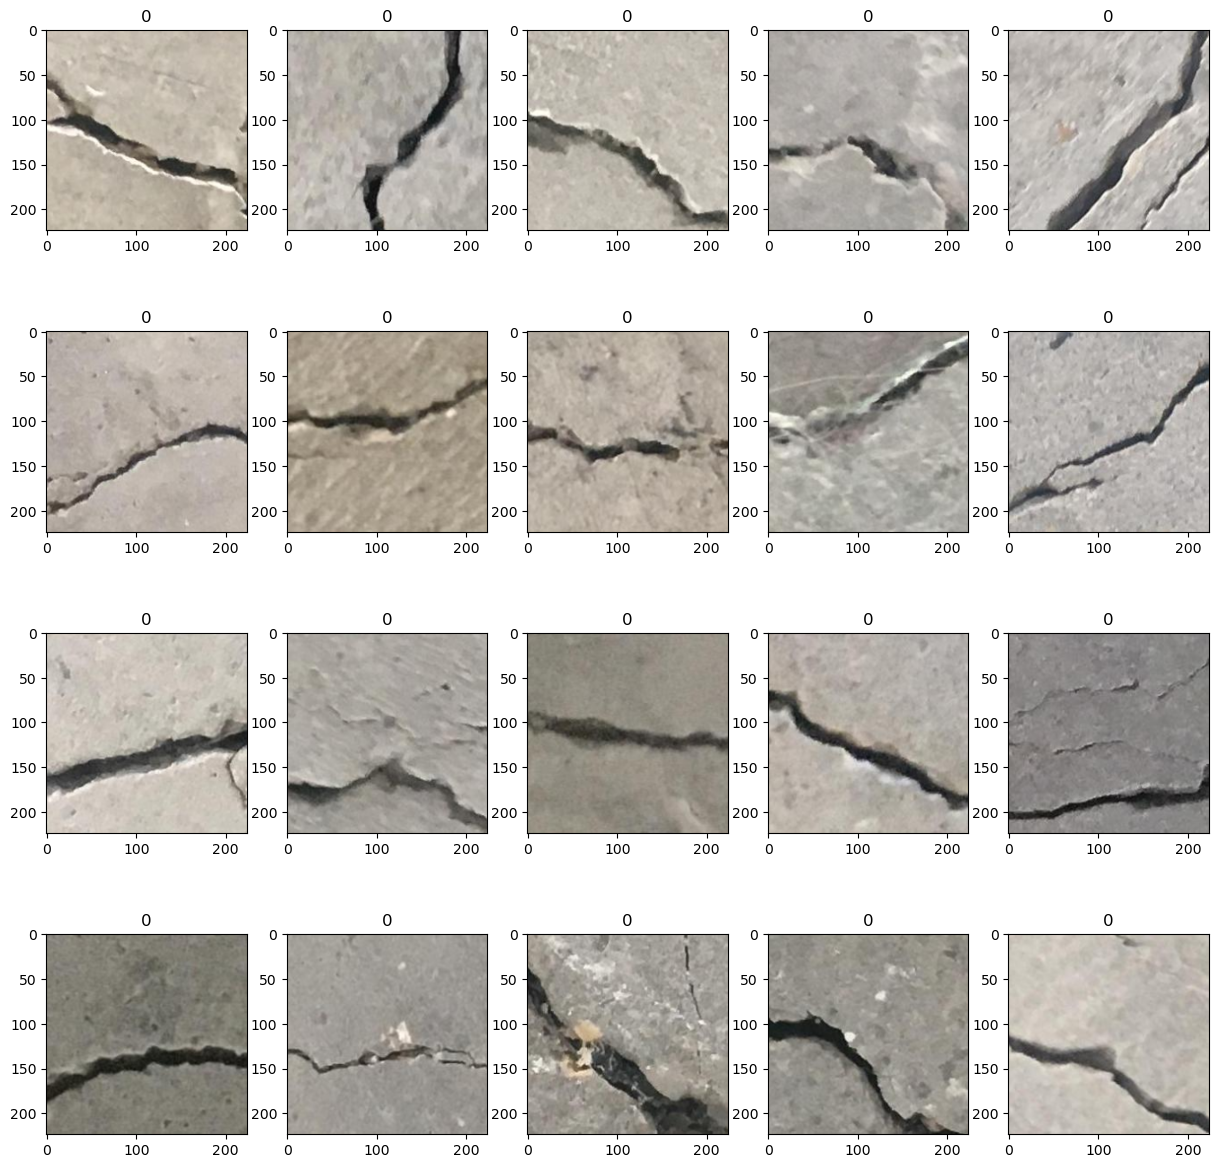

In [25]:
plt.figure(figsize=(15, 15))

for i in range(5, 25):
    ax = plt.subplot(4, 5, i-5+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(total_preds[i].cpu().item())